# Bleurt evaluation against ChatGPT summary

This notebook tries to understand if there is a good correlation between the Bleurt score comparing a good summary (in this case a summary done by ChatGPT) and the student summary, with the content score.


In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
#DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"
DATA_DIR = "../input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

prompts_train_ref = pd.read_csv("../input/prompt_ref_summaries.csv")

In [3]:
prompts_train = prompts_train.merge(prompts_train_ref, on="prompt_id", how="left")

In [4]:
tr = summaries_train.merge(prompts_train, on="prompt_id", how="left")

In [5]:
tokenizer = AutoTokenizer.from_pretrained("Elron/bleurt-base-512")
model = AutoModelForSequenceClassification.from_pretrained("Elron/bleurt-base-512")
model.eval()
model.to("cuda")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('local/deepbox'), PosixPath('@/tmp/.ICE-unix/4917,unix/deepbox')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/etc/xdg/xdg-plasma')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/org/freedesktop/DisplayManager/Session1')}
  warn(msg)
/home/pedro/py310/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/share/gconf/plasma.mandatory.path')}
  warn(msg

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [7]:
def eval_bleurt(data, ref_col, cand_col, model, tokenizer, batchsize=200):
    n_splits = len(data)//batchsize 
    allscores = []
    with torch.no_grad():
        for batch in np.array_split(data[[ref_col, cand_col]].values, n_splits):
            inputs = tokenizer(batch[:,0].tolist(), batch[:,1].tolist(), return_tensors='pt', padding=True, truncation=True)
            inputs = {k:v.to("cuda") for k,v in inputs.items()}
            scores = model(**inputs)[0].squeeze().detach().cpu().numpy()
            allscores += scores.tolist()
    return allscores

In [9]:
tr["bleurt"] = eval_bleurt(tr, "_llama2_summ", "text", model, tokenizer, batchsize=200)

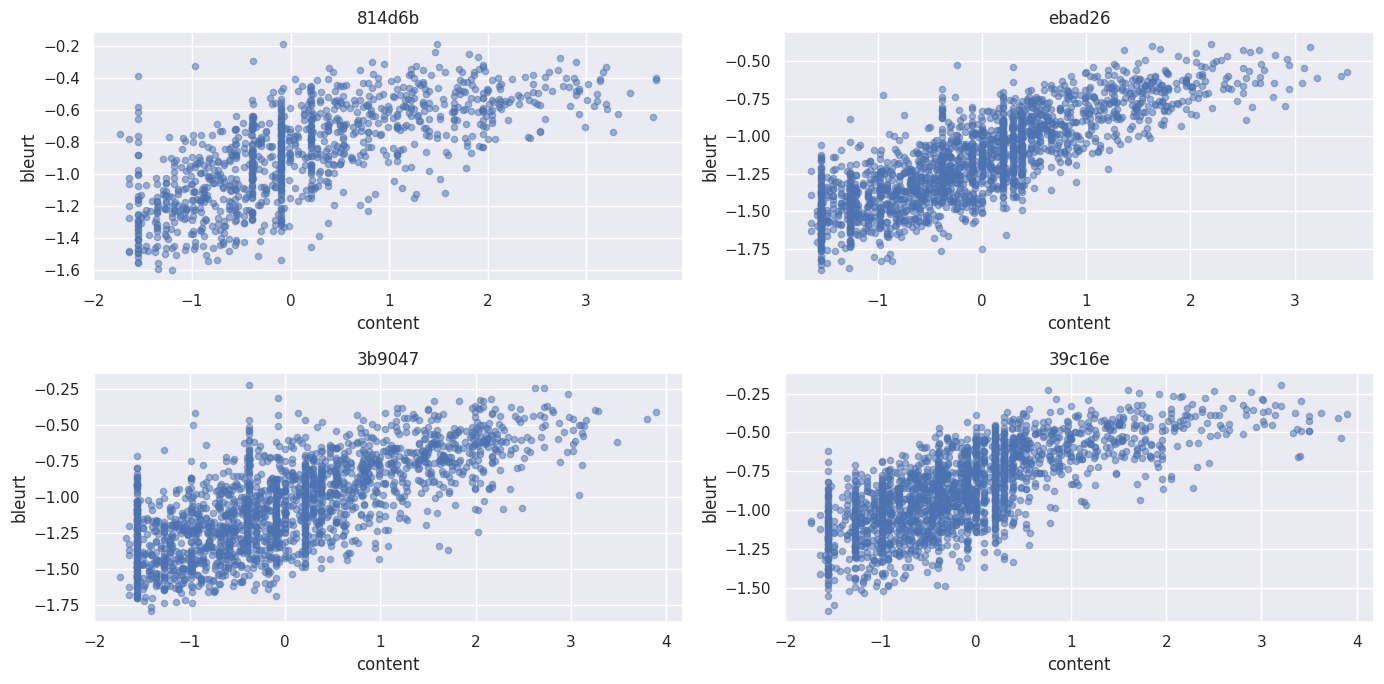

In [10]:
_, ax = plt.subplots(2,2, figsize=(14,7))
ax = ax.flatten()
for idx, pid in enumerate(tr.prompt_id.unique()):
    tr[tr.prompt_id==pid].plot.scatter(x="content", y="bleurt", alpha=0.5, ax=ax[idx])
    ax[idx].set_title(pid)
plt.tight_layout();

In [11]:
for idx, pid in enumerate(tr.prompt_id.unique()):
    corr = tr[tr.prompt_id==pid][["content", "bleurt"]].corr().values[0][1]
    print(pid, corr)

814d6b 0.7044763873224682
ebad26 0.8300089525090183
3b9047 0.7134194149244318
39c16e 0.716490424073895


### Evaluate Bleurt with raw full prompt

In [12]:
sep = " [SEP] "
tr["full_prompt"] = (tr["prompt_title"] + sep 
                        + tr["prompt_question"] + sep 
                        + tr["prompt_text"])

In [13]:
tr["bleurt_fp"] = eval_bleurt(tr, "full_prompt", "text", model, tokenizer, batchsize=200)

In [14]:
for idx, pid in enumerate(tr.prompt_id.unique()):
    corr = tr[tr.prompt_id==pid][["content", "bleurt_fp"]].corr().values[0][1]
    print(pid, corr)

814d6b 0.7917414020189247
ebad26 0.814113279129657
3b9047 0.7723197778648614
39c16e 0.8055486744761744


### Evaluate Bleurt with fixed summary

Maybe summaries with spelling errors fixed will correlated better 

In [15]:
from autocorrect import Speller

In [16]:
speller = Speller(lang='en')

In [17]:
tr["fixed_summary"] = tr.text.apply(lambda x: speller(x))

In [18]:
tr["bleurt_fp_fs"] = eval_bleurt(tr, "full_prompt", "fixed_summary", model, tokenizer, batchsize=200)

In [19]:
for idx, pid in enumerate(tr.prompt_id.unique()):
    corr = tr[tr.prompt_id==pid][["content", "bleurt_fp_fs"]].corr().values[0][1]
    print(pid, corr)

814d6b 0.8118908046384352
ebad26 0.8073553483214637
3b9047 0.8066004776428526
39c16e 0.8262807953706311
